In [1]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/automatida-taxi-trip-data/2017_Yellow_Taxi_Trip_Data.csv
/kaggle/input/2017-yellow-taxi-trip-data-csv/2017_Yellow_Taxi_Trip_Data (1).csv


In [2]:
#Import relevant packages and libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, mean_absolute_error, r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression


In [3]:
#Import dataset into dataframe

df0 = pd.read_csv('/kaggle/input/2017-yellow-taxi-trip-data-csv/2017_Yellow_Taxi_Trip_Data (1).csv')

df = df0.copy()
#make sure dataset loaded correctly
df.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,24870114,2,03/25/2017 8:55:43 AM,03/25/2017 9:09:47 AM,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56
1,35634249,1,04/11/2017 2:53:28 PM,04/11/2017 3:19:58 PM,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80
2,106203690,1,12/15/2017 7:26:56 AM,12/15/2017 7:34:08 AM,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75
3,38942136,2,05/07/2017 1:17:59 PM,05/07/2017 1:48:14 PM,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69
4,30841670,2,04/15/2017 11:32:20 PM,04/15/2017 11:49:03 PM,1,4.37,1,N,4,112,2,16.5,0.5,0.5,0.00,0.0,0.3,17.80


## Conducting EDA

Firstly I will view and inspect summary information about the dataset

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22699 entries, 0 to 22698
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             22699 non-null  int64  
 1   VendorID               22699 non-null  int64  
 2   tpep_pickup_datetime   22699 non-null  object 
 3   tpep_dropoff_datetime  22699 non-null  object 
 4   passenger_count        22699 non-null  int64  
 5   trip_distance          22699 non-null  float64
 6   RatecodeID             22699 non-null  int64  
 7   store_and_fwd_flag     22699 non-null  object 
 8   PULocationID           22699 non-null  int64  
 9   DOLocationID           22699 non-null  int64  
 10  payment_type           22699 non-null  int64  
 11  fare_amount            22699 non-null  float64
 12  extra                  22699 non-null  float64
 13  mta_tax                22699 non-null  float64
 14  tip_amount             22699 non-null  float64
 15  to

We have 2 datatime variables and one string, all other are numeric, I want to check if N in store_and_fwd_flag column stands for No

In [5]:
df['store_and_fwd_flag'].unique()

array(['N', 'Y'], dtype=object)

Yep that's correct it should be a boolean variable, I would transform it later

In [6]:
df.describe()

,Unnamed: 0,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
count,2.269900e+04,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000
mean,5.675849e+07,1.556236,1.642319,2.913313,1.043394,162.412353,161.527997,1.336887,13.026629,0.333275,0.497445,1.835781,0.312542,0.299551,16.310502
std,3.274493e+07,0.496838,1.285231,3.653171,0.708391,66.633373,70.139691,0.496211,13.243791,0.463097,0.039465,2.800626,1.399212,0.015673,16.097295
min,1.212700e+04,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,-120.000000,-1.000000,-0.500000,0.000000,0.000000,-0.300000,-120.300000
25%,2.852056e+07,1.000000,1.000000,0.990000,1.000000,114.000000,112.000000,1.000000,6.500000,0.000000,0.500000,0.000000,0.000000,0.300000,8.750000
50%,5.673150e+07,2.000000,1.000000,1.610000,1.000000,162.000000,162.000000,1.000000,9.500000,0.000000,0.500000,1.350000,0.000000,0.300000,11.800000
75%,8.537452e+07,2.000000,2.000000,3.060000,1.000000,233.000000,233.000000,2.000000,14.500000,0.500000,0.500000,2.450000,0.000000,0.300000,17.800000
max,1.134863e+08,2.000000,6.000000,33.960000,99.000000,265.000000,265.000000,4.000000,999.990000,4.500000,0.500000,200.000000,19.100000,0.300000,1200.290000


total_amount and tip_amount columns are worth further investigation because of the extreme max values 

In [7]:
#converting data columns to datetime
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])

In [8]:
df.sort_values(['total_amount'], ascending=False)['total_amount'].head(10)

8476     1200.29
20312     450.30
13861     258.21
12511     233.74
15474     211.80
6064      179.06
16379     157.06
3582      152.30
11269     151.82
9280      150.30
Name: total_amount, dtype: float64

In [9]:
df.sort_values(['total_amount'], ascending=True)['total_amount'].head(10)

12944   -120.3
20698     -5.8
17602     -5.8
11204     -5.3
14714     -5.3
8204      -4.8
20317     -4.8
10281     -4.3
5448      -4.3
4423      -4.3
Name: total_amount, dtype: float64

So there are at least 2 outliers i think the max and min values from this variable are seemed to extreme.
And I shoul ask dataset provider what negative total_amount could mean, maybe it's compensation for something.

In [10]:
df['payment_type'].value_counts()

payment_type
1    15265
2     7267
3      121
4       46
Name: count, dtype: int64

According to the dictionary of the dataset
1= Credit card 
2= Cash 
3= No charge 
4= Dispute

I'd like to check on credid card and cash tip payments

In [11]:
avg_cc_tip  = df[df['payment_type']==1]['tip_amount'].mean()
avg_cash_tip = df[df['payment_type']==2]['tip_amount'].mean()
print('Avg credit card tip: ', avg_cc_tip)
print('Avg credit card tip: ', avg_cash_tip)

Avg credit card tip:  2.7298001965280054
Avg credit card tip:  0.0


Now check for missing data and duplicates

In [12]:
df.isna().sum()

Unnamed: 0               0
VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
store_and_fwd_flag       0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
dtype: int64

There is no missing values

In [13]:
df.duplicated().sum()

0

And also no duplicates

## Visualization

Text(0.5, 1.0, 'trip distance histogram')

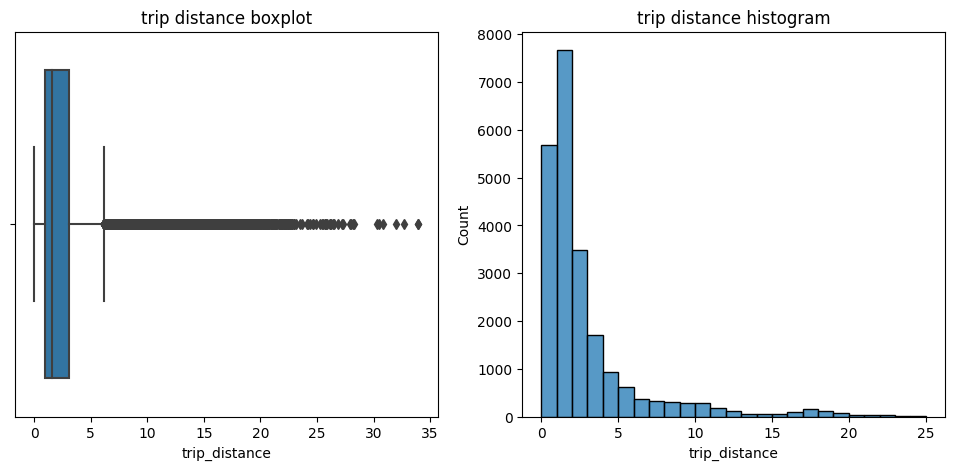

In [14]:
# box plot of trip_distance
fig,ax = plt.subplots(1,2, figsize=(12,5))

sns.boxplot(x=df['trip_distance'],ax=ax[0])
ax[0].set_title("trip distance boxplot")

sns.histplot(df["trip_distance"], bins=range(0,26,1), ax=ax[1])
ax[1].set_title("trip distance histogram")

Majority of trips were less than 3 miles and as distance increases amount of trips significantly falls

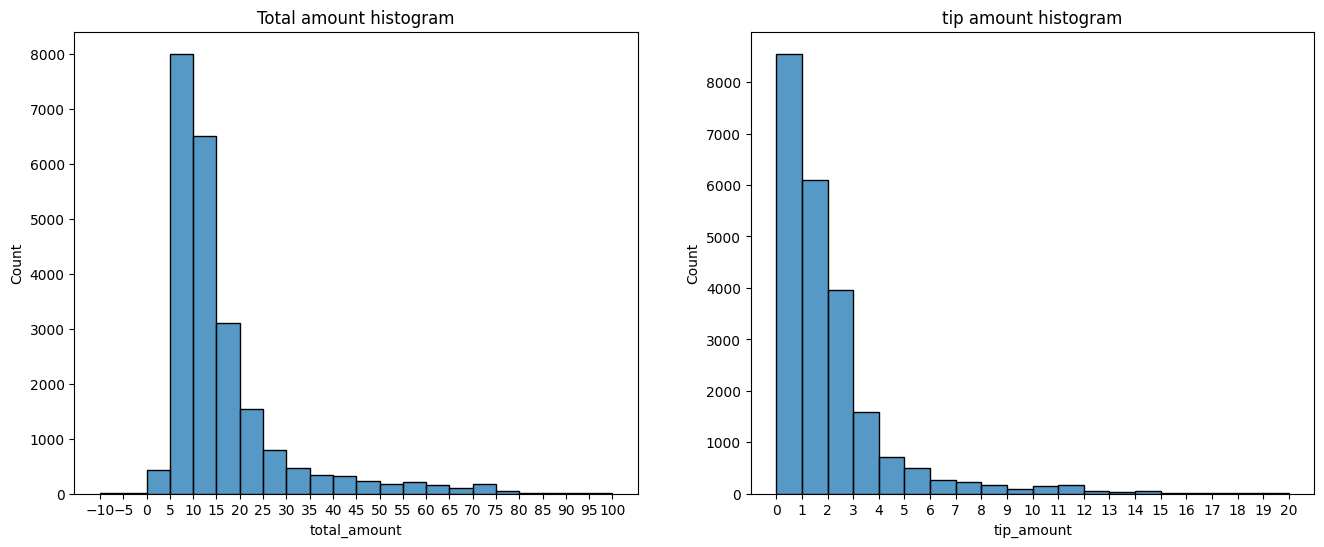

In [15]:
fig, ax = plt.subplots(1,2, figsize=(16,6))
sns.histplot(data=df, x='total_amount', bins=range(-10,101,5), ax=ax[0])
ax[0].set_title("Total amount histogram")
ax[0].set_xticks(range(-10,101,5))

sns.histplot(data=df, x='tip_amount', bins=range(0,21,1), ax=ax[1])
ax[1].set_title("tip amount histogram")
ax[1].set_xticks(range(0,21,1))
plt.show()

The total cost of each trip and total tip amount are also have a distribution that skews right, with most costs falling in the $5-15 range, and tip falling in the $0-3 range

In [16]:
#Creating month and day columns
df['month'] = df['tpep_pickup_datetime'].dt.month_name()
df['day'] = df['tpep_pickup_datetime'].dt.day_name()

In [17]:
#Total rides by month
monthly_rides = df['month'].value_counts()
monthly_rides

month
March        2049
October      2027
April        2019
May          2013
January      1997
June         1964
December     1863
November     1843
February     1769
September    1734
August       1724
July         1697
Name: count, dtype: int64

In [18]:
#for better view we should reorder our mothly rides

month_order = ['January', 'February', 'March', 'April', 'May', 
               'June', 'July', "August", 'September', 'October', 'November', 'December']

monthly_rides = monthly_rides.reindex(index=month_order)
monthly_rides

month
January      1997
February     1769
March        2049
April        2019
May          2013
June         1964
July         1697
August       1724
September    1734
October      2027
November     1843
December     1863
Name: count, dtype: int64

In [19]:
daily_rides = df['day'].value_counts()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_rides = daily_rides.reindex(index=day_order)
daily_rides

day
Monday       2931
Tuesday      3198
Wednesday    3390
Thursday     3402
Friday       3413
Saturday     3367
Sunday       2998
Name: count, dtype: int64

Text(0.5, 1.0, 'Rides by day')

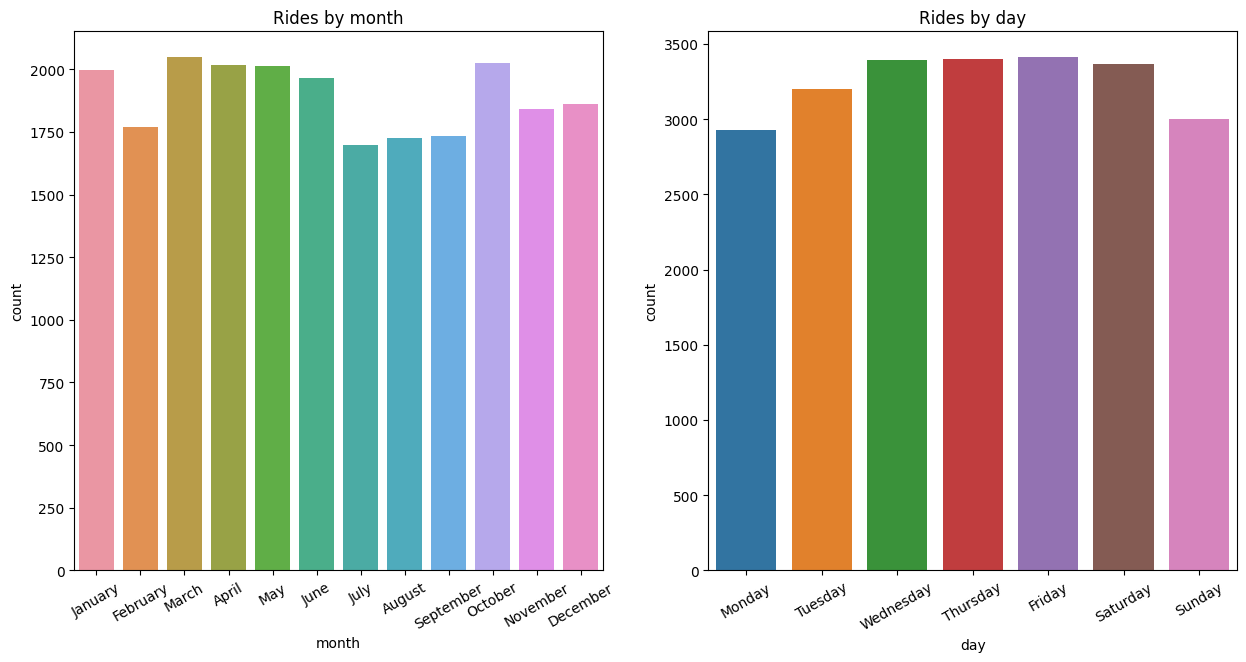

In [20]:
fig, ax = plt.subplots(1,2,figsize=(15,7))
sns.barplot(x=monthly_rides.index, y=monthly_rides, ax=ax[0])
ax[0].set_xticklabels(month_order, rotation=30)
ax[0].set_title("Rides by month")

sns.barplot(x=daily_rides.index, y=daily_rides, ax=ax[1])
ax[1].set_xticklabels(day_order, rotation=30)
ax[1].set_title("Rides by day")

Surprisingly Wednesdat through Saturday have the highest number of daily rides.
And monthly rides are pretty consistent with a little dips in February and summer months

In [21]:
len(df['DOLocationID'].unique())

216

There are 216 drop off location, let's check them

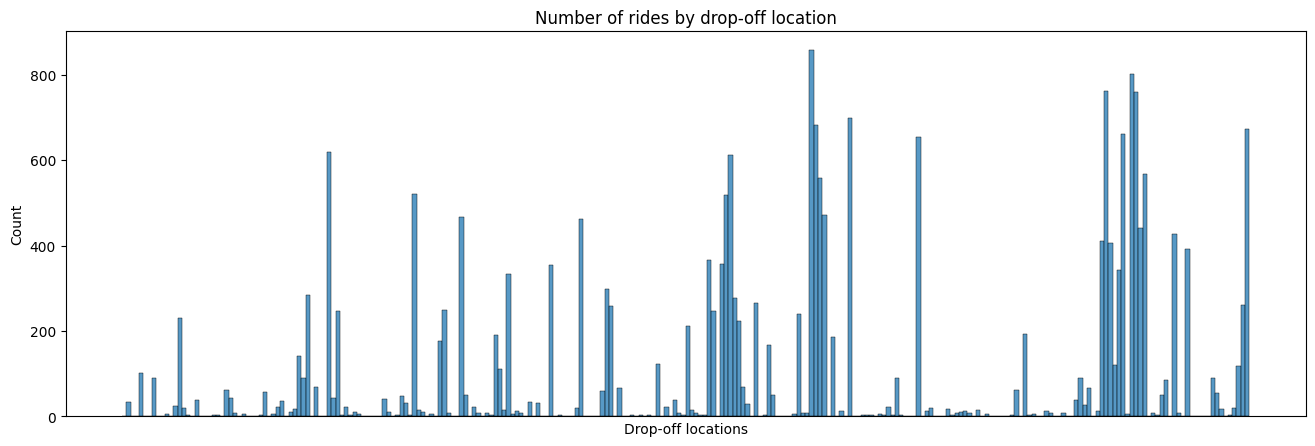

In [22]:
plt.figure(figsize=(16,5))

sns.histplot(df['DOLocationID'], bins=range(0,df['DOLocationID'].max(), 1))
plt.xticks([])
plt.xlabel('Drop-off locations')
plt.title("Number of rides by drop-off location")
plt.show()

Out of 200+ location just a small number of locations recieve the majority of the traffic.

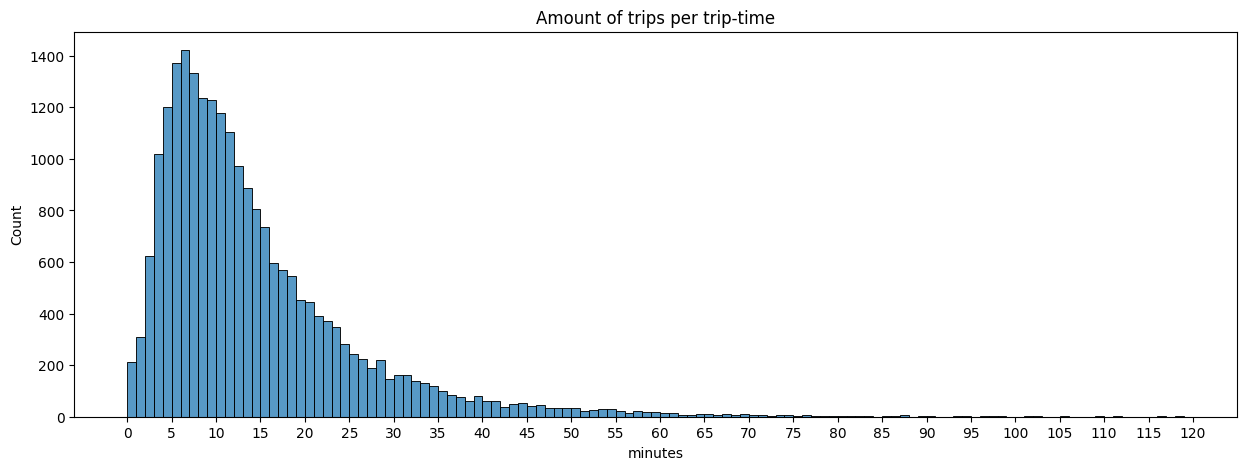

In [23]:
df['trip_duration'] = (df['tpep_dropoff_datetime']-df['tpep_pickup_datetime']).dt.total_seconds()/60


plt.figure(figsize=(15,5))
sns.histplot(df['trip_duration'], bins=range(0,120))
plt.title("Amount of trips per trip-time")
plt.xticks(ticks=range(0,121,5))
plt.xlabel("minutes")
plt.show()

Majority of trips fall between 3 to 30 minutes time periods

### Checking for outliers
Keeping in mind that many of the features will not be used to fit the model, the most important would probably be: 
* trip_distance
* fare_amount
* trip_duration

So it would be nice to check them for outliers

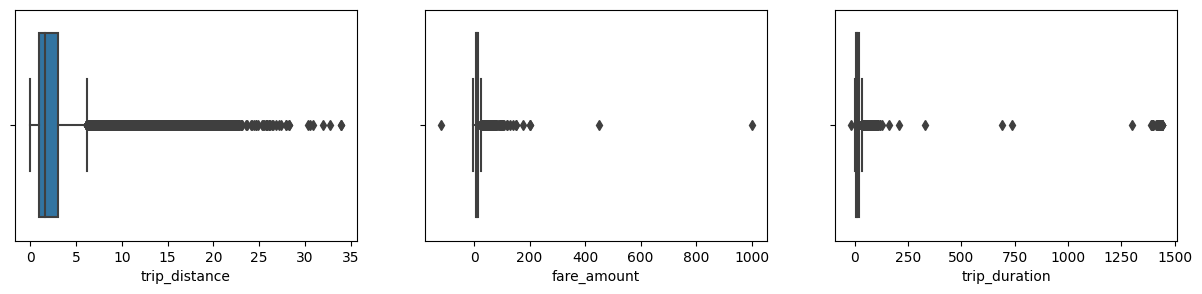

In [24]:
fig, ax = plt.subplots(1,3,figsize=(15,3))
sns.boxplot(x=df['trip_distance'], ax=ax[0])
sns.boxplot(x=df['fare_amount'], ax=ax[1])
sns.boxplot(x=df['trip_duration'], ax=ax[2])
plt.show()

1. All three contain outliers. Some are extreme but others not so much
2. Since data comes from NYC taxi trips it's reasonable to leave outliers for trip_distance variable because 30-35 miles trips could occur in such a big city.
3. However the values for other two variables seem to have problematic outliers on higher end.

#### trip_distance outliers
We know that there are trip with distance of 0, is it just rounded short trips or precise values?

In [25]:
sorted(set(df['trip_distance']))[:10]

[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]

As we can see distance in this dataset is measured quite precisely so i think that trips with distance values could be that person ordered taxi and didn't went somewhere but was charged anyway.


In [26]:
#Let's check how many such entries are there
(df['trip_distance']==0).sum()

148

out of 23000 entries it's very small number, so i will keep them

#### fare_amount outliers


In [27]:
df['fare_amount'].describe()

count    22699.000000
mean        13.026629
std         13.243791
min       -120.000000
25%          6.500000
50%          9.500000
75%         14.500000
max        999.990000
Name: fare_amount, dtype: float64

Negative values are definietly not legitimate, but value of zero could be true, if trip was immediately canceled.

In [28]:
#let's impute negative values with 0
df.loc[df['fare_amount'] < 0, 'fare_amount'] = 0


In [29]:
q1 = df['fare_amount'].quantile(0.25)
q3 = df['fare_amount'].quantile(0.75)
iqr = q3 - q1
print("IQR: ", iqr, "$")
upper_threshold = q3 + 1.5*iqr
print("upper_threshold: ", upper_threshold, "$")

IQR:  8.0 $
upper_threshold:  26.5 $


Dealing with outliers with standard formula of Q3 + (1,5 * IQR) doesn't seems to be appropriate for the maximum cap. Based on intuition and statistics in this case we'll use a factor of 6.

In [30]:
#and create function to deal with high value otliers
def outlier_impute(col_name, iqr_factor):
    '''
    impute upper-limit values in specified column based on its interquartile range.
    
    Arguments:
        col_name: Name of column to impute, string.
        iqr_factor: A number representing X in the formula:
                    Q3 + (X*IQR) used to determine maximum threshold
                
    '''
    #calculating upper threshold
    q1 = df[col_name].quantile(0.25)
    q3 = df[col_name].quantile(0.75)
    iqr = q3 - q1
    upper_threshold = q3 + iqr_factor*iqr
    print('q3: ', q3)
    print('upper_threshold: ', upper_threshold)
    
    #reassign values
    df.loc[df[col_name] > upper_threshold, col_name] = upper_threshold
    print(df[col_name].describe())

In [31]:
#pass our column to the function
outlier_impute('fare_amount', 6)

q3:  14.5
upper_threshold:  62.5
count    22699.000000
mean        12.897913
std         10.541137
min          0.000000
25%          6.500000
50%          9.500000
75%         14.500000
max         62.500000
Name: fare_amount, dtype: float64


#### trip_duration outliers

In [32]:
#let's impute negative values with 0
df.loc[df['trip_duration'] < 0, 'trip_duration'] = 0
outlier_impute('trip_duration', 6)

q3:  18.383333333333333
upper_threshold:  88.78333333333333
count    22699.000000
mean        14.460555
std         11.947043
min          0.000000
25%          6.650000
50%         11.183333
75%         18.383333
max         88.783333
Name: trip_duration, dtype: float64


## Feature engineering

When model will be deployed it will not know the duration of the trip, so we cannot use this feature to train our model. But we can use statistics of trips to generalize about ones we do not know

I will create columns with average distance between pickup and drop-off point

In [33]:
df['pickup_dropoff'] = df['PULocationID'].astype(str) + ' ' + df['DOLocationID'].astype(str)
df['pickup_dropoff'].head()

0    100 231
1     186 43
2    262 236
3     188 97
4      4 112
Name: pickup_dropoff, dtype: object

In [34]:
#now let's calculate mean distance for pairs of locations
grouped_loc = df.groupby(by='pickup_dropoff').mean(numeric_only=True)[['trip_distance']]
grouped_loc.head()

,trip_distance
pickup_dropoff,
1 1,2.433333
10 148,15.700000
100 1,16.890000
100 100,0.253333
100 107,1.180000


In [35]:
#convertin grouped locations to a dictionary
grouped_dict = grouped_loc.to_dict()

#reassign to only contain the inner dictionary
grouped_dict = grouped_dict['trip_distance']


In [36]:
#Creating a mean_distange column out of pickup_dropoff helper columns
df['mean_distance'] = df['pickup_dropoff']

#now we can map our distance columns with dictionary we created
df['mean_distance'] = df['mean_distance'].map(grouped_dict)

#let's check if it worked
df[(df['PULocationID'] == 1) & (df['DOLocationID'] == 1)][['mean_distance']]

,mean_distance
3582,2.433333
6485,2.433333
13359,2.433333


#### Mean_duration column
Now I will repeat same process to create mean_duration column

In [37]:
grouped_dur = df.groupby(by='pickup_dropoff').mean(numeric_only=True)[['trip_duration']]
grouped_dur.head()

,trip_duration
pickup_dropoff,
1 1,0.466667
10 148,69.366667
100 1,48.183333
100 100,3.130556
100 107,11.200000


In [38]:
#convertin grouped locations to a dictionary and reassign to only contain the inner dictionary
grouped_dict = grouped_dur.to_dict()
grouped_dict = grouped_dict['trip_duration']

#Creating a mean_duration column out of pickup_dropoff helper columns
df['mean_duration'] = df['pickup_dropoff']

#now we can map our distance columns with dictionary we created
df['mean_duration'] = df['mean_duration'].map(grouped_dict)

#let's check if it worked
df[(df['PULocationID'] == 1) & (df['DOLocationID'] == 1)][['mean_duration']]

,mean_duration
3582,0.466667
6485,0.466667
13359,0.466667


In [39]:
#get the columns names
df.head(2)

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,...,tip_amount,tolls_amount,improvement_surcharge,total_amount,month,day,trip_duration,pickup_dropoff,mean_distance,mean_duration
0,24870114,2,2017-03-25 08:55:43,2017-03-25 09:09:47,6,3.34,1,N,100,231,...,2.76,0.0,0.3,16.56,March,Saturday,14.066667,100 231,3.521667,22.847222
1,35634249,1,2017-04-11 14:53:28,2017-04-11 15:19:58,1,1.80,1,N,186,43,...,4.00,0.0,0.3,20.80,April,Tuesday,26.500000,186 43,3.108889,24.470370


## Rush hour column
Rush hour would be on the weekdays in the morning and in the evening when people go to work and come home from work respectively

rush hour:
* Any weekday (not Saturday or Sunday) AND
* Either from 06:00–10:00 or from 16:00–20:00

In [40]:
df['rush_hour'] = df['tpep_pickup_datetime'].dt.hour
#if day is falls on weekends impute 0 in the 'rush_hour' column
df.loc[df['day'].isin(['Saturday', 'Sunday']), 'rush_hour'] = 0

In [41]:
def rush_hourizer(hour):
    if 6 <= hour['rush_hour'] < 10:
        val = 1
    elif 16 <= hour['rush_hour'] < 20:
        val = 1
    else:
        val = 0
    return val

In [42]:
#apply function to the new columns
df.loc[~df['day'].isin(['Saturday', 'Sunday']), 'rush_hour'] = df.apply(rush_hourizer, axis=1)
#check if it worked
df[['tpep_pickup_datetime', 'day', 'rush_hour']].head(10)

,tpep_pickup_datetime,day,rush_hour
0,2017-03-25 08:55:43,Saturday,0
1,2017-04-11 14:53:28,Tuesday,0
2,2017-12-15 07:26:56,Friday,1
3,2017-05-07 13:17:59,Sunday,0
4,2017-04-15 23:32:20,Saturday,0
5,2017-03-25 20:34:11,Saturday,0
6,2017-05-03 19:04:09,Wednesday,1
7,2017-08-15 17:41:06,Tuesday,1
8,2017-02-04 16:17:07,Saturday,0
9,2017-11-10 15:20:29,Friday,0


## Scatter plot
Check relationship between mean_duration and fare_amount

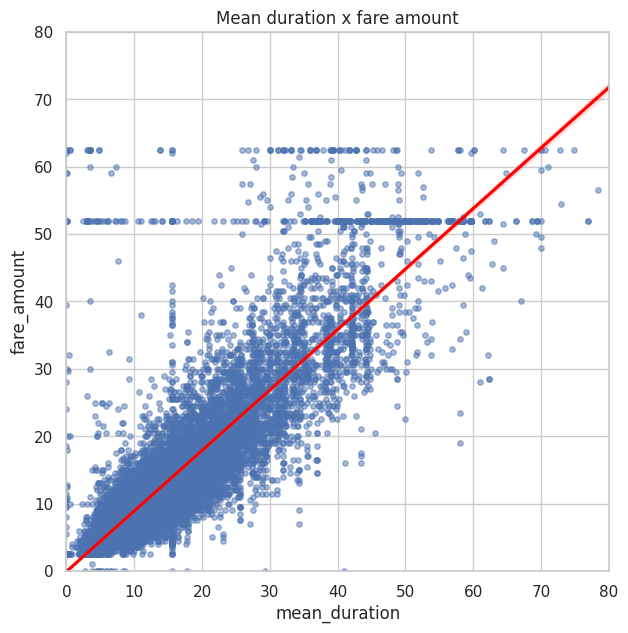

In [43]:
plt.figure(figsize=(7,7))
sns.set(style='whitegrid')
sns.regplot(x=df['mean_duration'], y=df['fare_amount'], scatter_kws={'alpha':0.5, 's':15}, line_kws={'color':'red'})

plt.title("Mean duration x fare amount")
plt.ylim(0,80)
plt.xlim(0,80)
plt.show()

mean_duration correlates with the target variable. But strange horizontal lines aroud fare amount of 52 and 63 dollars apper.

We know taht 63 dollar line represents outliers that we have imputer, but what is the other line?

In [44]:
df[df['fare_amount'] > 50]['fare_amount'].value_counts().head()

fare_amount
52.0    514
62.5     84
59.0      9
50.5      9
57.5      8
Name: count, dtype: int64

Wow 514 trips that are exactly 52 dollars, let's check them

In [45]:
df[df['fare_amount'] == 52].head(20)

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,...,tolls_amount,improvement_surcharge,total_amount,month,day,trip_duration,pickup_dropoff,mean_distance,mean_duration,rush_hour
11,18600059,2,2017-03-05 19:15:30,2017-03-05 19:52:18,2,18.90,2,N,236,132,...,5.54,0.3,72.92,March,Sunday,36.800000,236 132,19.211667,40.500000,0
110,47959795,1,2017-06-03 14:24:57,2017-06-03 15:31:48,1,18.00,2,N,132,163,...,0.00,0.3,52.80,June,Saturday,66.850000,132 163,19.229000,52.941667,0
161,95729204,2,2017-11-11 20:16:16,2017-11-11 20:17:14,1,0.23,2,N,132,132,...,0.00,0.3,52.80,November,Saturday,0.966667,132 132,2.255862,3.021839,0
247,103404868,2,2017-12-06 23:37:08,2017-12-07 00:06:19,1,18.93,2,N,132,79,...,0.00,0.3,52.80,December,Wednesday,29.183333,132 79,19.431667,47.275000,0
379,80479432,2,2017-09-24 23:45:45,2017-09-25 00:15:14,1,17.99,2,N,132,234,...,5.76,0.3,73.20,September,Sunday,29.483333,132 234,17.654000,49.833333,0
388,16226157,1,2017-02-28 18:30:05,2017-02-28 19:09:55,1,18.40,2,N,132,48,...,5.54,0.3,62.84,February,Tuesday,39.833333,132 48,18.761905,58.246032,1
406,55253442,2,2017-06-05 12:51:58,2017-06-05 13:07:35,1,4.73,2,N,228,88,...,5.76,0.3,58.56,June,Monday,15.616667,228 88,4.730000,15.616667,0
449,65900029,2,2017-08-03 22:47:14,2017-08-03 23:32:41,2,18.21,2,N,132,48,...,5.76,0.3,58.56,August,Thursday,45.450000,132 48,18.761905,58.246032,0
468,80904240,2,2017-09-26 13:48:26,2017-09-26 14:31:17,1,17.27,2,N,186,132,...,5.76,0.3,58.56,September,Tuesday,42.850000,186 132,17.096000,42.920000,0
520,33706214,2,2017-04-23 21:34:48,2017-04-23 22:46:23,6,18.34,2,N,132,148,...,0.00,0.3,57.80,April,Sunday,71.583333,132 148,17.994286,46.340476,0


All of 20 head records seem to have the same Ratecode ID and all of them either start or end at 132 location ID

The data dictionary says that RatecodeID of 2 indicates trips for JFK, which is John F. Kennedy International Airport. A quick Google search for "new york city taxi flat rate $52" indicates that in 2017 (the year that this data was collected) there was indeed a flat fare for taxi trips between JFK airport (in Queens) and Manhattan.

### Isolate modeling variables
I'll drop features that are irrelevant or thoose that will not be available in a deployed model


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22699 entries, 0 to 22698
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Unnamed: 0             22699 non-null  int64         
 1   VendorID               22699 non-null  int64         
 2   tpep_pickup_datetime   22699 non-null  datetime64[ns]
 3   tpep_dropoff_datetime  22699 non-null  datetime64[ns]
 4   passenger_count        22699 non-null  int64         
 5   trip_distance          22699 non-null  float64       
 6   RatecodeID             22699 non-null  int64         
 7   store_and_fwd_flag     22699 non-null  object        
 8   PULocationID           22699 non-null  int64         
 9   DOLocationID           22699 non-null  int64         
 10  payment_type           22699 non-null  int64         
 11  fare_amount            22699 non-null  float64       
 12  extra                  22699 non-null  float64       
 13  m

In [47]:
df_subset = df.copy()
df_subset = df_subset[['VendorID', 'passenger_count', 'fare_amount', 'mean_distance', 'mean_duration', 'rush_hour']]
df_subset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22699 entries, 0 to 22698
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   VendorID         22699 non-null  int64  
 1   passenger_count  22699 non-null  int64  
 2   fare_amount      22699 non-null  float64
 3   mean_distance    22699 non-null  float64
 4   mean_duration    22699 non-null  float64
 5   rush_hour        22699 non-null  int64  
dtypes: float64(3), int64(3)
memory usage: 1.0 MB


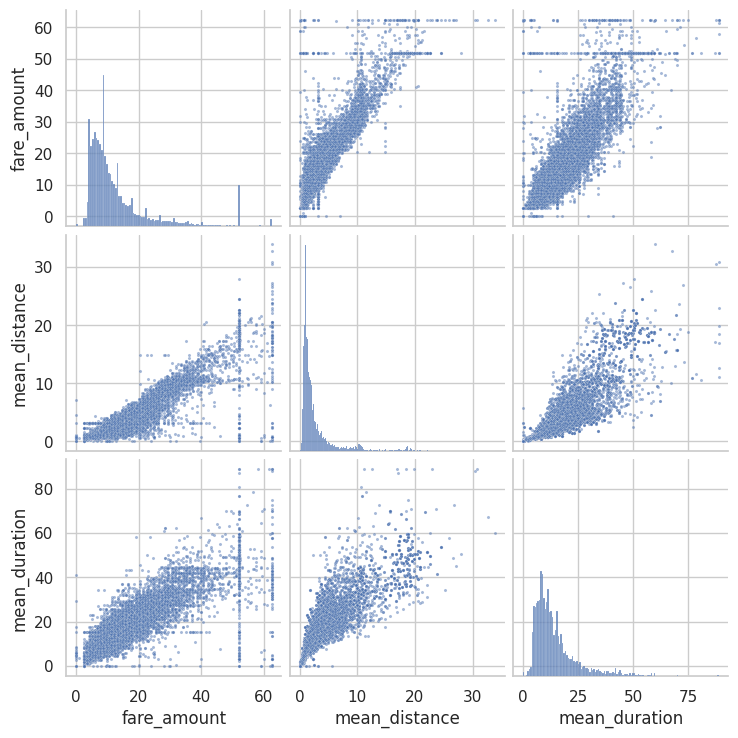

In [48]:
#creating a pairplot to visualize pairwise relationships between fare_amount, mean_duration and mean_distance

sns.pairplot(df_subset[['fare_amount', 'mean_distance', 'mean_duration']], plot_kws={'alpha':0.5, 's':5})

These variables all show linear correlation with each other

In [49]:
#create correlation matrix using pearson correlation coefficient
df_subset.corr(method='pearson')

,VendorID,passenger_count,fare_amount,mean_distance,mean_duration,rush_hour
VendorID,1.000000,0.266463,0.001045,0.004741,0.001876,-0.002874
passenger_count,0.266463,1.000000,0.014942,0.013428,0.015852,-0.022035
fare_amount,0.001045,0.014942,1.000000,0.910185,0.859105,-0.020075
mean_distance,0.004741,0.013428,0.910185,1.000000,0.874864,-0.039725
mean_duration,0.001876,0.015852,0.859105,0.874864,1.000000,-0.021583
rush_hour,-0.002874,-0.022035,-0.020075,-0.039725,-0.021583,1.000000


Better to use visualization

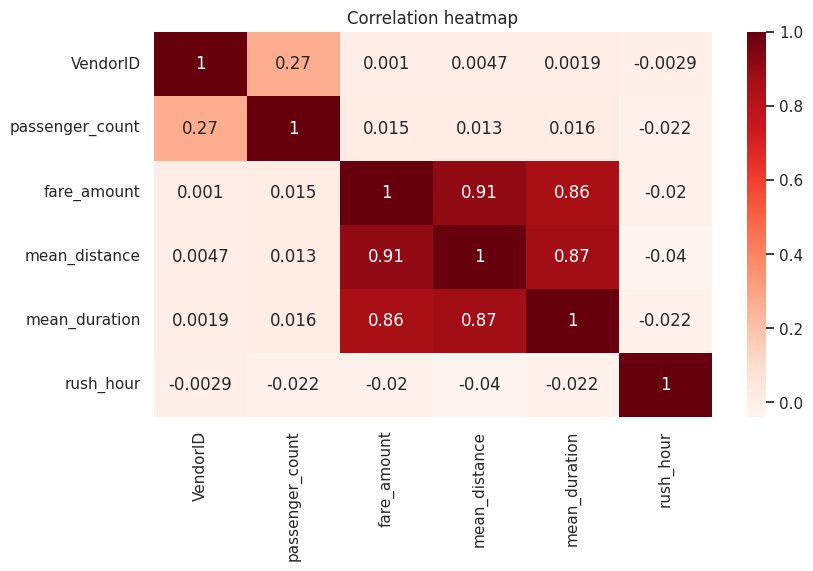

In [50]:
plt.figure(figsize=(9,5))
sns.heatmap(df_subset.corr(method='pearson'), annot=True, cmap='Reds')
plt.title("Correlation heatmap")
plt.show()

Both mean_distance and mean_duration are highly correlated with our target variable fare_amount. And they are both correlated with each other.

Highly correlated predictor variables can be bad for linear regression models when you want to be able to draw statistical inferences about the data from the model.
But we want to predict fare_amount which will be used as a predictor variable in machine learning models, so let's try to keep these variables and see what happens.

## Split data into outcome variable and features

In [51]:
y = df_subset['fare_amount']

X = df_subset.drop(columns=['fare_amount'])

Dummy encoding VendorID variable

In [52]:
#convert vendorid to str so we could use get_dummies function
X['VendorID'] = X['VendorID'].astype(str)
# get dummies, since we got only 2 vendors we can drop first vendor column
X = pd.get_dummies(X, drop_first=True, dtype='int')
X.head()

,passenger_count,mean_distance,mean_duration,rush_hour,VendorID_2
0,6,3.521667,22.847222,0,1
1,1,3.108889,24.470370,0,0
2,1,0.881429,7.250000,1,0
3,1,3.700000,30.250000,0,1
4,1,4.435000,14.616667,0,1


### split data into training and test sets

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state=42)

### Fit the model

In [54]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

### Evaluate model

#### Train data

In [55]:
r_sq = lr.score(X_train, y_train)
print('Coefficient of determination: ', r_sq)
y_pred = lr.predict(X_train)
print('R^2: ', r2_score(y_train, y_pred))
print('MAE:', mean_absolute_error(y_train, y_pred))
print('MSE:', mean_squared_error(y_train, y_pred))
print('RMSE:',np.sqrt(mean_squared_error(y_train, y_pred)))

Coefficient of determination:  0.8488017574563115
R^2:  0.8488017574563115
MAE: 2.1819245956286473
MSE: 17.088312217818014
RMSE: 4.13380118266687


#### Test data

In [56]:
r_sq_test = lr.score(X_test, y_test)
print('Coefficient of determination: ', r_sq_test)
y_pred_test = lr.predict(X_test)
print('R^2: ', r2_score(y_test, y_pred_test))
print('MAE:', mean_absolute_error(y_test, y_pred_test))
print('MSE:', mean_squared_error(y_test, y_pred_test))
print('RMSE:',np.sqrt(mean_squared_error(y_test, y_pred_test)))

Coefficient of determination:  0.8304785329674023
R^2:  0.8304785329674023
MAE: 2.124781414213244
MSE: 17.52179121269477
RMSE: 4.185903870455552


Model performs high on both train and test data, which means that the model is not overfit.

For the test data an R^2 of 0.83 means that 83% of the variance in the fare_amount is described by the model

### Results

get actual predicted and residual values for testing set

In [57]:
#Result dataframe

result = pd.DataFrame({'actual':y_test,
                       'predicted':y_pred_test})
result['residual'] = result['actual'] - result['predicted']
result.head()

,actual,predicted,residual
9199,12.5,9.582803,2.917197
4955,6.0,8.608098,-2.608098
16833,12.0,9.179057,2.820943
13244,20.5,20.628286,-0.128286
1063,14.0,15.324450,-1.324450


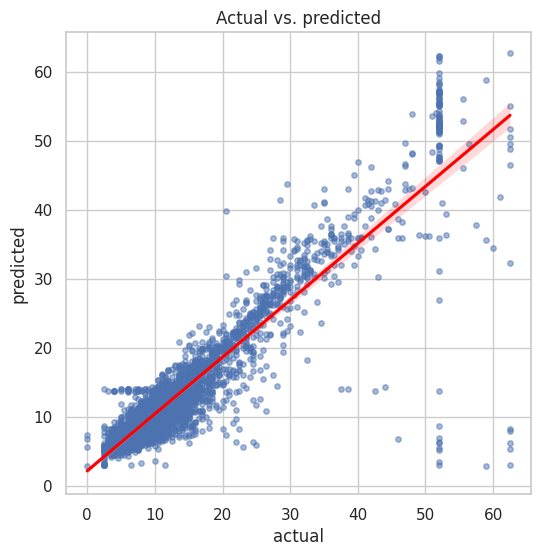

In [58]:
#visualization of results

plt.figure(figsize=(6,6))
sns.set(style=('whitegrid'))
sns.regplot(data=result, x='actual', y='predicted', scatter_kws={'alpha':0.5, 's':15}, line_kws={'color':'red'})
plt.title("Actual vs. predicted")
plt.show()

Text(0.5, 1.0, 'Distribution of the residuals')

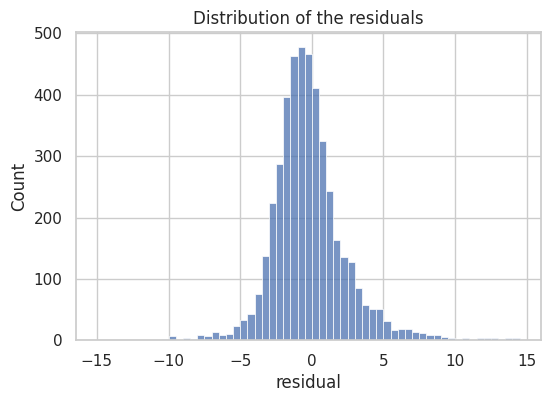

In [59]:
#Visualize distribution of the residuals
plt.figure(figsize=(6,4))
sns.histplot(result['residual'], bins=np.arange(-15,15,0.5))
plt.title("Distribution of the residuals")

In [60]:
result['residual'].mean()

0.05448356587313024

The distribution of the residuals is approximately normal and has a mean of 0.054. A normal distribution around zero is good, as it demonstrates that the model's errors are evenly distributed and unbiased.

### Coefficients

In [61]:
lr_coef = lr.coef_
lr_coef = lr_coef.reshape((1,5))
print(lr_coef)

[[ 0.0116146   2.00475247  0.27811445  0.29887346 -0.06337254]]


In [62]:
#getting model coefficients
coefficients = pd.DataFrame(lr_coef, columns=X.columns)
coefficients

,passenger_count,mean_distance,mean_duration,rush_hour,VendorID_2
0,0.011615,2.004752,0.278114,0.298873,-0.063373


Coefficients reveal that mean_distance was the feature with the greatest weight in the model's final prediction.
Fare increases by a mean of $2.00 for every 1 mile traveled

As a result of this notebook I can discuss meeting linear regression assumprions and I can preset the MAE and RMSE scores obtained from the model.